# Filtros digitales a partir de filtros analógicos
<img src="./img/logo_UTN.svg" align="right" width="150" /> 

#### Por Mariano Llamedo Soria

### Resumen 

En este documento se presenta el método de diseño de filtros digitales a partir de las mismas metodologías usadas para diseñar filtros analógicos. Se trata de un método sub-óptimo que se basa en la transforada bilineal.

* Funciones de análisis de sistemas lineales: [group_delay](), [analyze_sys](), [plot_plantilla]() 
* Funciones para presentación de markdown y latex: [print_latex](), [print_subtitle](), [a_equal_b_latex_s]()


Se inicializa el entorno de simulación con los módulos utilizados.


In [1]:

import sympy as sp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# Gráficos interactivos
# %matplotlib ipympl
# Gráficos estáticos
#%matplotlib inline

from pytc2.sistemas_lineales import group_delay, analyze_sys, plot_plantilla
from pytc2.general import print_latex, print_subtitle, a_equal_b_latex_s


### Transformada bilineal

La transformada bilineal es una técnica que permite relacionar los filtros analógicos y digitales al mapear el plano complejo del dominio de Laplace de una función de transferencia analógica al plano complejo del dominio Z de una función de transferencia digital. Esto se logra mediante el núcleo de la transformación:

$$ s = \frac{2}{T} \cdot \frac{1 - z^{-1}}{1 + z^{-1}} = 2 \cdot f_S \cdot \frac{z-1}{z+1} $$

Donde:

* $s$ es la variable compleja en el dominio de Laplace (analógico).
* $T = \frac{1}{f_S}$ es el período de muestreo en segundos, o el recíproco de la frecuencia de muestreo.
* $z$ es la variable compleja en el dominio Z (digital).

La transformada bilineal es útil porque preserva la ubicación relativa de las frecuencias en la transformación de un filtro analógico a uno digital. Esto significa que las características de frecuencia y la respuesta de un filtro analógico se conservan de manera aproximada en su versión digital, lo que facilita la transición entre ambos dominios, y sobretodo, **nos permite portar el conocimiento de los sistemas analógicos al mundo digital**. 

Se comienza con un ejemplo en el que se convertirá un filtro pasabajos Butterworth normalizado a su versión digital.


In [2]:

#%% Resolución simbólica 

s, z = sp.symbols('s z', complex=True)
k_sym, fs, Q, w0 = sp.symbols('k fs Q w0', real=True, positive=True)

Ts = w0**2/(s**2+s*w0/Q+w0**2)
fz = k_sym * (z-1)/(z+1)

Tz = sp.collect(sp.simplify(sp.expand(sp.simplify(sp.expand(Ts.subs(s, fz))))), z)


print_latex(a_equal_b_latex_s('T(s)', Ts))
print_latex(a_equal_b_latex_s(r'T(z) = T(s) \Big\vert_{s = k_sym \cdot \frac{z - 1}{z + 1}}', Tz))


# display(Tz.subs(k_sym, 2*fs))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Como se puede notar, la expresión de $T(z)$ se complica **notablemente** respecto a la expresión original de $T(s)$. Esto pone de manifiesto que el abordaje y diseño de los filtros digitales, rara vez se abordará desde el *lápiz y papel*, y por lo general se realizará mediante **métodos numéricos**.

### Análisis numérico

Recordar que la transformada bilineal requiere que se defina un **único** parámetro $k=2.f_S$, pero que puede alterarse de forma tal de compensar la falta de linealidad (*warping*) al mapear las frecuencias analógicas y digitales. Para ello basta con definir 

$$ k = \frac{2\omega_0}{\tan(\frac{\omega_0}{2.f_S})}, $$

siendo $\omega_0$ la pulsación analógica a la cual se pretende lograr que $T(z=1.e^{j\Omega_0}) = T(s=j\omega_0)$. Es decir que tanto la transferencia analógica como digital, serán **exactamente iguales** en módulo y fase **solo** para $\omega_0$

En el siguiente ejemplo se demuestra el uso de la transformada bilineal para tres frecuencias de muestreo relativas a la frecuencia de corte analógica (3, 5, y 10 veces $\omega_0$), donde se calcula el *k de prewarping* para cada filtro digital resultante, de forma tal que **coincidan las tres transferencias** a la frecuencia de corte del filtro analógico.

(0.0, 5.0)

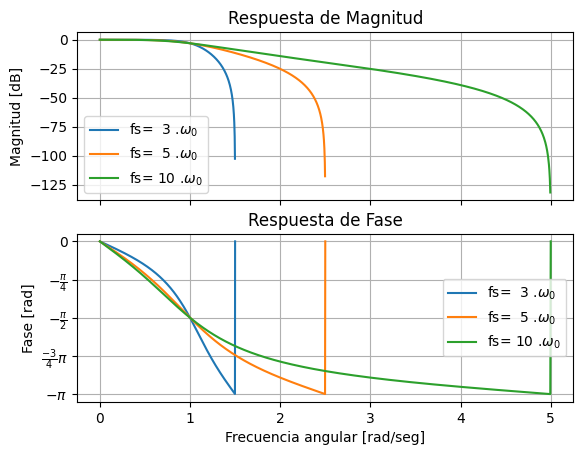

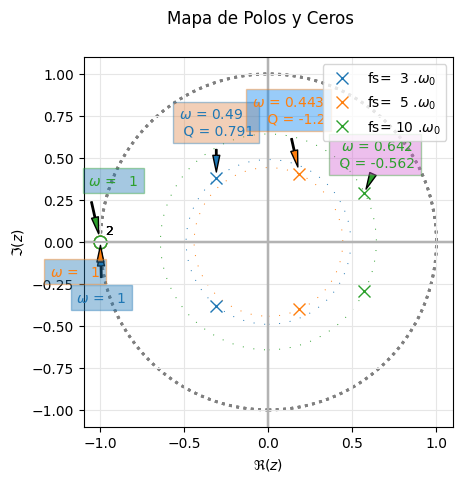

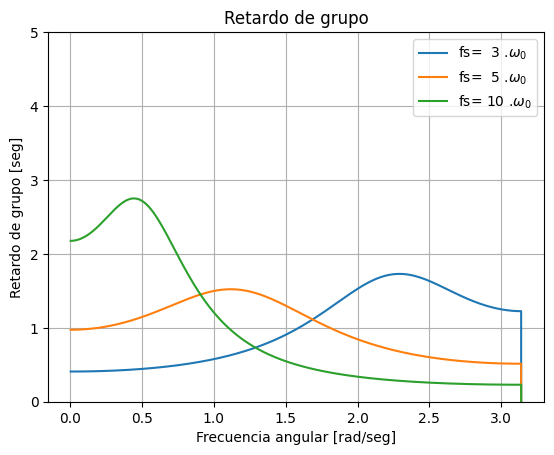

In [3]:
#%matplotlib ipympl

# filtro analógico Butterworth normalizado
ww = 1 # r/s
QQ = np.sqrt(2)/2

# w0=2*np.pi*f0, entonces la mínima frecuencia para que f0 esté en banda digital:
# > 1 * w0/2/np.pi
allfs = np.array([ 3, # correctamente muestreado
                   5, # holgadamente muestreado
                   10 ]) * ww/2/np.pi # sobremuestreado

all_sys = []
all_sys_desc = []

plt.close('all')

for this_fs in allfs:

    # sin prewarp
    # k_bilineal = 2*this_fs; 

    # con prewarp
    # prewarping a w0 = ww = 1 (frecuencia de corte)
    k_bilineal = ww/np.tan(ww/2/this_fs); 

    thiz_tz = sp.simplify(sp.expand(Tz.subs({k_sym:k_bilineal, Q:QQ, w0:ww})))
    
    num, den = sp.fraction(thiz_tz)

    num = sp.Poly(num,z)
    den = sp.Poly(den,z)

    numz = np.array(num.all_coeffs()).astype(np.float64)
    denz = np.array(den.all_coeffs()).astype(np.float64)

    my_df = sig.TransferFunction(numz, denz, dt=1/this_fs)

    all_sys += [my_df]
    all_sys_desc += ['fs={:3.0f} .$\omega_0$'.format(this_fs/(ww/2/np.pi))]

# Visualizamos su respuesta en frecuencia
figaxes = analyze_sys(all_sys, all_sys_desc)


# Haremos notar que el prewarp es capaz de fijar la igualdad de la respuesta 
# del sistema independientemente de la frecuencia de muestreo.

# Respuesta de módulo acotada
# figaxes[0][1][0].set_ylim(bottom=-10, top=2)

# Respuesta de retardo
figaxes[3][1].set_ylim(bottom=0, top=5)



Notar que para $T(e^{j1}) = T(j1)$, todas las respuestas coinciden con la respuesta del prototipo analógico, ya que así lo forzamos en la constante $k$ que utilizamos para el *prewarping*.

Esto no necesariamente es así si se utliza la constante $k = 2.f_S$ como se muestra en el siguiente ejemplo, **sin modificar el prototipo analógico**, se obtienen tres filtros digitales diferentes:

(0.0, 5.0)

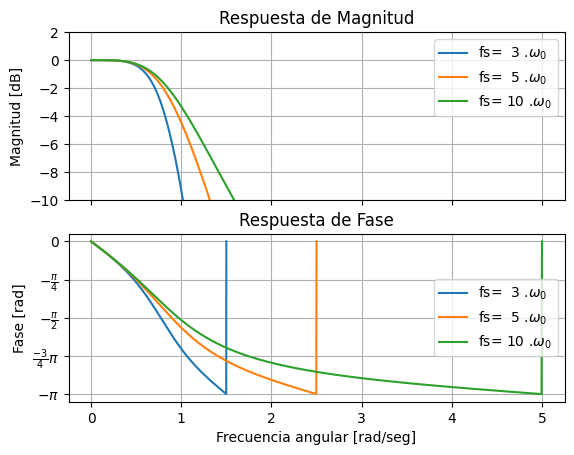

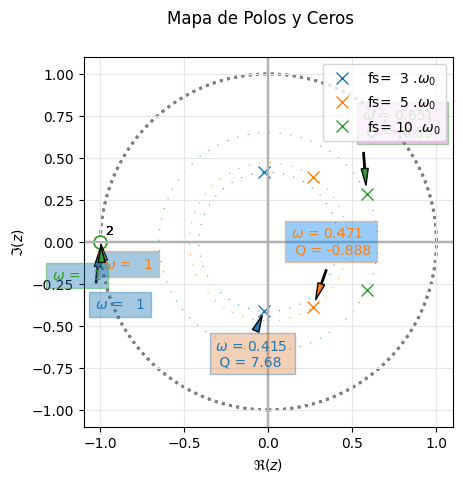

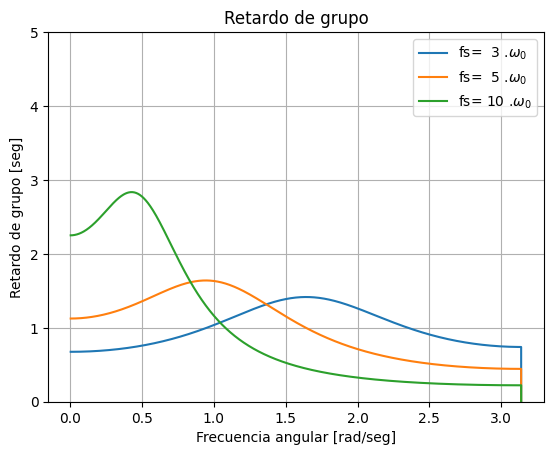

In [10]:
all_sys = []
all_sys_desc = []

plt.close('all')

for this_fs in allfs:

    # sin prewarp
    k_bilineal = 2*this_fs; 
    # con prewarp
    #k_bilineal = ww/np.tan(ww/2/this_fs); 

    thiz_tz = sp.simplify(sp.expand(Tz.subs({k_sym:k_bilineal, Q:QQ, w0:ww})))
    
    num, den = sp.fraction(thiz_tz)

    num = sp.Poly(num,z)
    den = sp.Poly(den,z)

    numz = np.array(num.all_coeffs()).astype(np.float64)
    denz = np.array(den.all_coeffs()).astype(np.float64)

    my_df = sig.TransferFunction(numz, denz, dt=1/this_fs)

    all_sys += [my_df]
    all_sys_desc += ['fs={:3.0f} .$\omega_0$'.format(this_fs/(ww/2/np.pi))]


# Visualizamos su respuesta en frecuencia
figaxes = analyze_sys(all_sys, all_sys_desc)

# Haremos notar que el prewarp es capaz de fijar la igualdad de la respuesta 
# del sistema independientemente de la frecuencia de muestreo.

# Respuesta de módulo
figaxes[0][1][0].set_ylim(bottom=-10,top=2)

# Respuesta de retardo
figaxes[3][1].set_ylim(bottom=0, top=5)



Luego, como son tres filtros digitales diferentes, existen diversas interpretaciones de sus respuestas de módulo y fase. Por ejemplo si analizamos los filtros implementados **a una misma frecuencia de muestreo normalizada**, se evidencian las diferencias en el ancho de banda digital normalizado **entre 0 y la frecuencia  de Nyquist**. 

**NOTA:** Se dejan comentados otros ejemplos para que los pruebe cada lector interesado.

(0.0, 5.0)

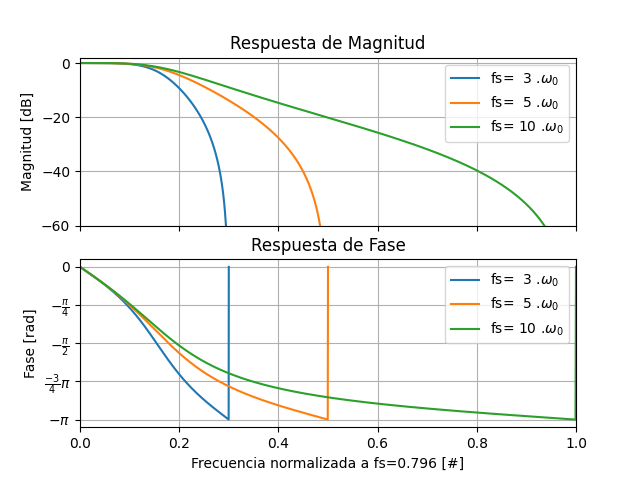

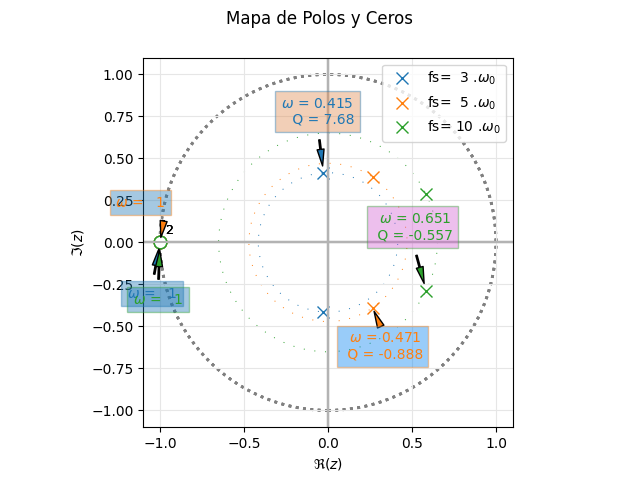

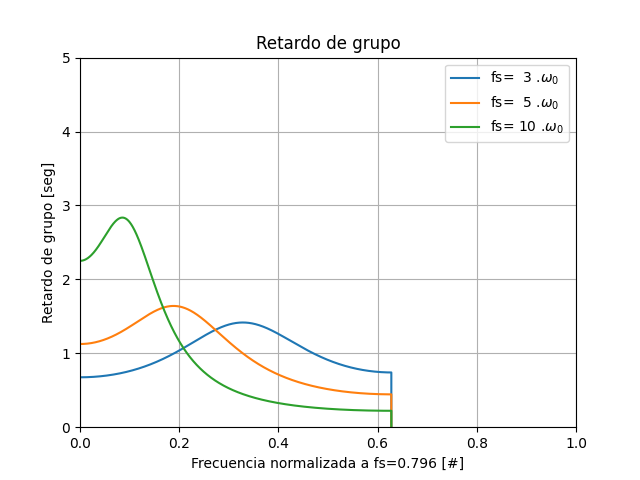

In [12]:
%matplotlib ipympl
# Desnormalizado en Hz
#figaxes = analyze_sys(all_sys, all_sys_desc, xaxis="freq")

# Normalizado individual de cada sistema
#figaxes = analyze_sys(all_sys, all_sys_desc, xaxis="norm")

# Normalizado respecto al de mayor fs (Hz)
figaxes = analyze_sys(all_sys, all_sys_desc, xaxis="norm", fs=allfs[-1]/2)

# Respuesta de módulo
figaxes[0][1][0].set_ylim(bottom=-60,top=2)

# Respuesta de retardo
figaxes[3][1].set_ylim(bottom=0, top=5)



### Diseño de filtros recursivos mediante la transformada bilineal

Una vez que comprendemos el uso de la transformada bilineal y cómo opera en la conversión de dominios, se puede avanzar en una metodología más completa, desde la elaboración de la plantilla del filtro objetivo hasta el análisis del filtro calculado. Procederemos con un ejemplo de diseño para un filtro pasabajo.

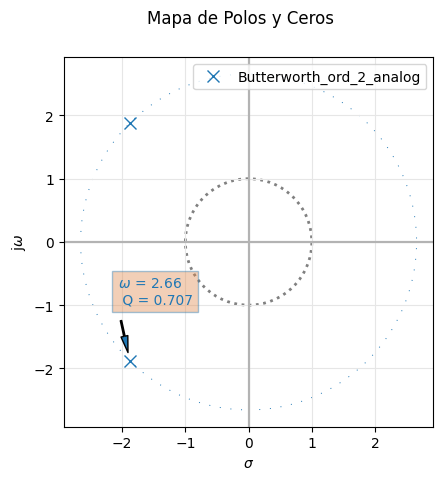

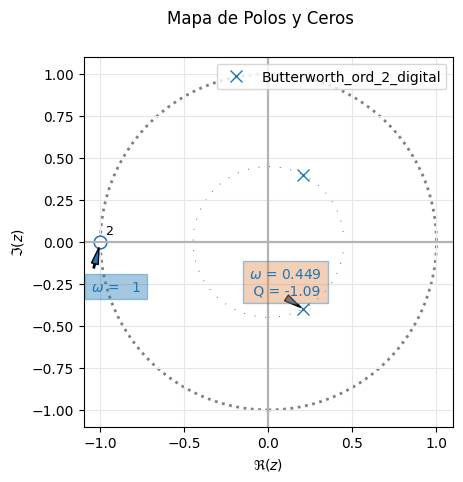

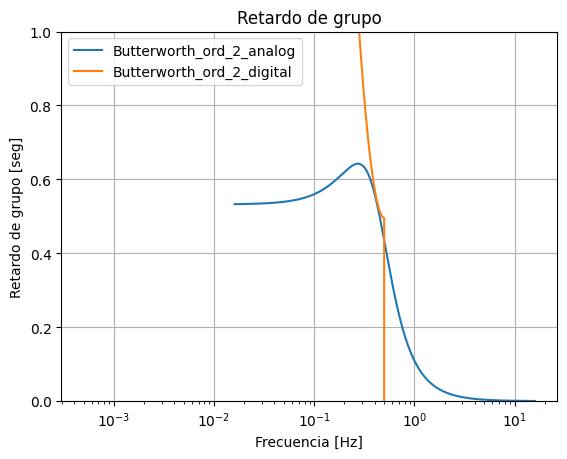

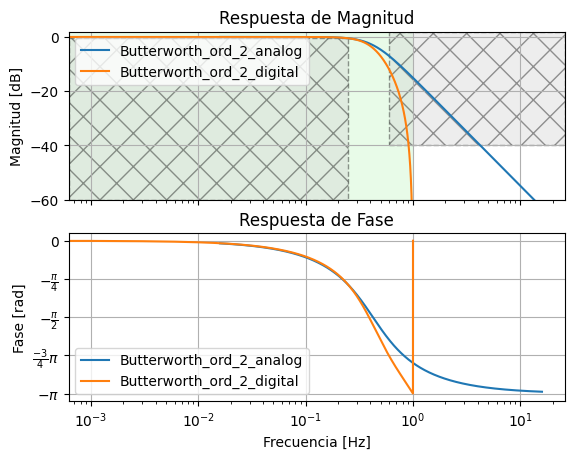

In [6]:
# Requerimientos de plantilla

# Tipo de aproximación.
aprox_name = 'Butterworth'
# aprox_name = 'Chebyshev1'
# aprox_name = 'Chebyshev2'
# aprox_name = 'Cauer'

# prototipo analógico
filter_type = 'lowpass'

f0 = 0.25 # normalizado respecto a nyq (fs/2)
ww0 =  2*np.pi*f0  # 

ripple = 0.5
attenuation = 40
order2analyze = 2

# para visualizar la plantilla
fpass = f0 # 
fstop = 0.6 # 


# frecuencia de muestreo (solo será útil para el caso desnormalizado)
fs = 2
# fs = 2*np.pi

# Prewarp
# la función bilinear de scipy espera la fs como parámetro de ajuste.
# por eso le pasaremos fpw/2.
# fpw = 2*fs; # sin prewarp
# prewarp para que se iguale la transferencia en módulo y fase para w0.
fpw = ww0/np.tan(ww0/2/fs)


all_sys = []
analog_filters = []
digital_filters = []

filter_names = []
analog_filters_names = []
digital_filters_names = []

if aprox_name == 'Butterworth':

    eps = np.sqrt(10**(ripple/10)-1)
    
    z,p,k = sig.buttap(order2analyze)

    # Desnormalizamos para cumplir con el ripple
    z, p, k = sig.lp2lp_zpk(z, p, k, wo=ww0*eps**(-1/order2analyze) )

elif aprox_name == 'Chebyshev1':

    z,p,k = sig.cheb1ap(order2analyze, ripple)

    z, p, k = sig.lp2lp_zpk(z, p, k, wo=ww0 )
    
elif aprox_name == 'Chebyshev2':

    z,p,k = sig.cheb2ap(order2analyze, attenuation)

    z, p, k = sig.lp2lp_zpk(z, p, k, wo= 2*np.pi*fstop )
    
elif aprox_name == 'Cauer':
   
    z,p,k = sig.ellipap(order2analyze, ripple, attenuation)

    z, p, k = sig.lp2lp_zpk(z, p, k, wo=ww0 )

num, den = sig.zpk2tf(z,p,k)

my_analog_filter = sig.TransferFunction(num,den)
my_analog_filter_desc = aprox_name + '_ord_' + str(order2analyze) + '_analog'

all_sys.append(my_analog_filter)
filter_names.append(my_analog_filter_desc)

analog_filters.append(my_analog_filter)
analog_filters_names.append(my_analog_filter_desc)

# Transformamos el filtroorder2analyze analógico mediante la transformada bilineal
numz, denz = sig.bilinear(num, den, fpw/2)

my_digital_filter = sig.TransferFunction(numz, denz, dt=1/fs)
my_digital_filter_desc = aprox_name + '_ord_' + str(order2analyze) + '_digital'

all_sys.append(my_digital_filter)
filter_names.append(my_digital_filter_desc)

figaxes = analyze_sys(all_sys, filter_names, xaxis = "freq")

figaxes[0][1][0].set_ylim(bottom=-60,top=2)

# Respuesta de retardo
figaxes[3][1].set_ylim(bottom=0, top=1)

# Respuesta de módulo
plt.sca(figaxes[0][1][0])

plot_plantilla(filter_type = filter_type , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)


Algunas observaciones sobre el diseño digital a partir del prototipo analógico:

* La transferencia de ambos filtros no coinciden, especialmente en las frecuencias cercanas a Nyquist.
* El filtro digital, al tener ceros en Nyquist (ver PZmap), decrece con mayor pendiente que el filtro analógico.
* Esto anticipa que para la plantilla del ejemplo, muy próxima en su transición a la frecuencia de Nyquist, el filtro digital (azul) cumplirá con el requerimiento mucho antes que el filtro analógico (naranja) a medida que se aumente el orden en las siguientes iteraciones.

Esto evidencia las **limitaciones** que tiene esta metodología para alcanzar una plantilla de diseño, y en los siguientes notebooks se presentarán herramientas más sofisticadas para el diseño digital directo.

Comenzaremos con aumentar el orden del filtro objetivo:

In [7]:
order2analyze = 5


Luego repetimos el diseño y análisis

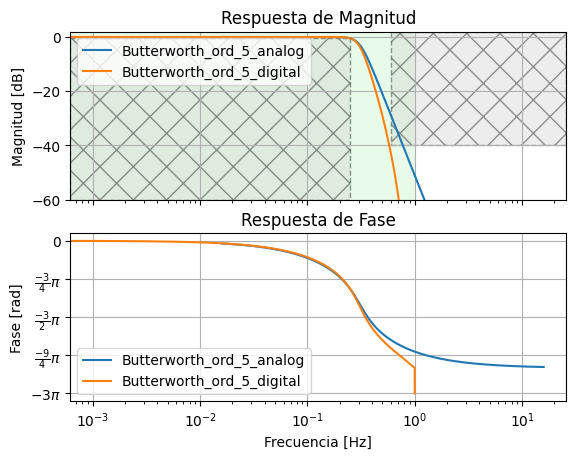

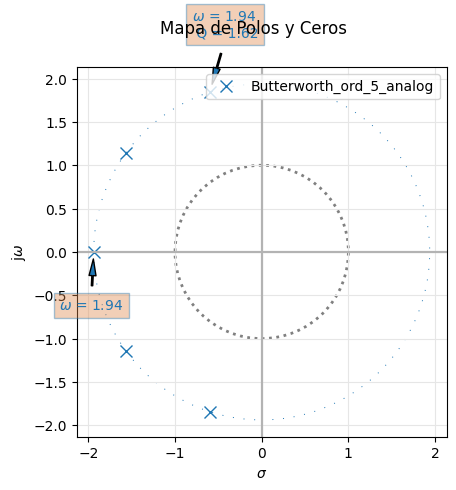

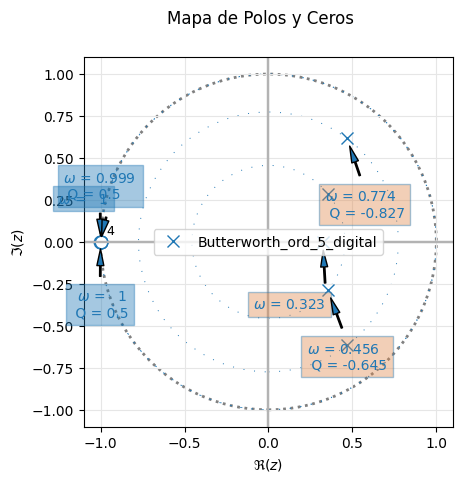

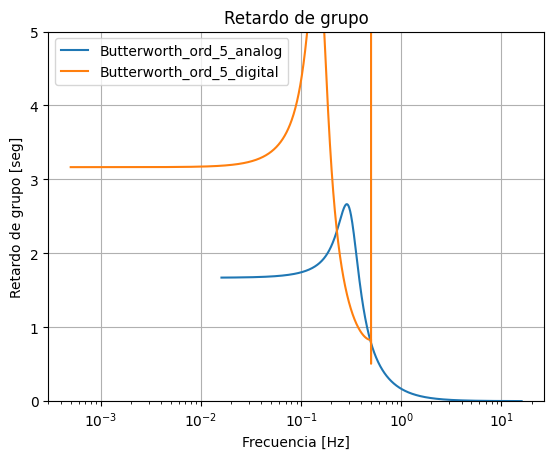

In [8]:
all_sys = []
analog_filters = []
digital_filters = []

filter_names = []
analog_filters_names = []
digital_filters_names = []

if aprox_name == 'Butterworth':

    eps = np.sqrt(10**(ripple/10)-1)
    
    z,p,k = sig.buttap(order2analyze)

    # Desnormalizamos para cumplir con el ripple
    z, p, k = sig.lp2lp_zpk(z, p, k, wo=ww0*eps**(-1/order2analyze) )

elif aprox_name == 'Chebyshev1':

    z,p,k = sig.cheb1ap(order2analyze, ripple)

    z, p, k = sig.lp2lp_zpk(z, p, k, wo=ww0 )
    
elif aprox_name == 'Chebyshev2':

    z,p,k = sig.cheb2ap(order2analyze, attenuation)

    z, p, k = sig.lp2lp_zpk(z, p, k, wo= 2*np.pi*fstop )
    
elif aprox_name == 'Cauer':
   
    z,p,k = sig.ellipap(order2analyze, ripple, attenuation)

    z, p, k = sig.lp2lp_zpk(z, p, k, wo=ww0 )

num, den = sig.zpk2tf(z,p,k)

my_analog_filter = sig.TransferFunction(num,den)
my_analog_filter_desc = aprox_name + '_ord_' + str(order2analyze) + '_analog'

all_sys.append(my_analog_filter)
filter_names.append(my_analog_filter_desc)

analog_filters.append(my_analog_filter)
analog_filters_names.append(my_analog_filter_desc)

# Transformamos el filtroorder2analyze analógico mediante la transformada bilineal
numz, denz = sig.bilinear(num, den, fpw/2)

my_digital_filter = sig.TransferFunction(numz, denz, dt=1/fs)
my_digital_filter_desc = aprox_name + '_ord_' + str(order2analyze) + '_digital'

all_sys.append(my_digital_filter)
filter_names.append(my_digital_filter_desc)

figaxes = analyze_sys(all_sys, filter_names, xaxis = "freq")

# Respuesta de módulo
figaxes[0][1][0].set_ylim(bottom=-60,top=2)

plt.sca(figaxes[0][1][0])

plot_plantilla(filter_type = filter_type , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)

# Respuesta de retardo
figaxes[3][1].set_ylim(bottom=0, top=5)

plt.figure(1)
plt.figure(2)
plt.figure(3)
plt.figure(4)
plt.show()

Se nota que el filtro digital **cumple** con la plantilla mientras que el analógico **no lo hace**. Esto demuestra que el método de diseño basado en la transformada bilineal tiene importantes limitaciones, que serán remediadas con herramientas más sofisticadas. Invitamos a quien tenga interés a revisar los siguientes notebooks.